\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# Question One {-}

In [1]:
import pandas as pd

bonds = pd.read_csv('bonds.txt', sep='\t', index_col=0)
# bonds = bonds[bonds['CouponRate'] > 6]
n = len(bonds)

bonds.head()

,CouponRate,BidPrice
Case,,
1,7.000,92.94
2,9.000,101.44
3,7.000,92.66
4,4.125,94.50
5,13.125,118.94


In [2]:
n

35

## 1. {-}

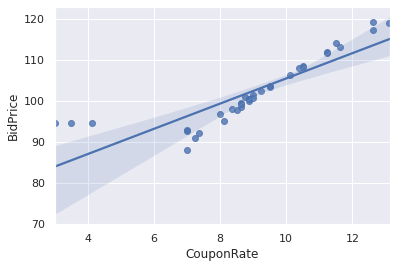

In [3]:
import seaborn as sns

sns.set_theme(color_codes=True)
ax = sns.regplot(x='CouponRate', y='BidPrice', data=bonds)

## 2. {-}

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

olsBonds = sm.OLS.from_formula(formula='BidPrice ~ CouponRate', data=bonds).fit()
olsBonds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BidPrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     99.87
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           1.64e-11
Time:                        05:04:44   Log-Likelihood:                -98.656
No. Observations:                  35   AIC:                             201.3
Df Residuals:                      33   BIC:                             204.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.7866      2.827     26.458      0.000      69.036      80.537
CouponRate     3.0661      0.307      9.994      0.000       2.442       3.690
==============================================================================
Omnibus:                        3.313   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.262
Skew:                           0.607   Prob(JB):                        0.323
Kurtosis:                       3.276   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. {-}

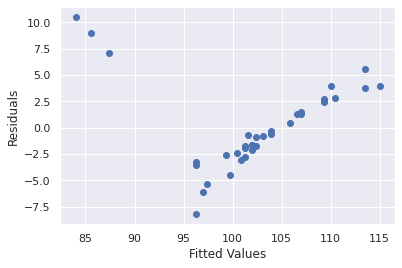

In [5]:
plt.scatter(olsBonds.fittedvalues, olsBonds.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

$$
\hat\beta_1 \pm z_{0.025}\text{SE}(\hat \beta_1)
$$
where the standard error is 
$$
\text{SE}(\hat\beta_1)\approx\frac{\hat\sigma}{s_x\sqrt{n-1}}
$$

$$
\hat\sigma^2 = \text{RSS}/(n-2)
$$

In [6]:
import numpy as np
from scipy.stats import norm, t

se = np.sqrt(olsBonds.ssr/(n-2))/(np.std(bonds['CouponRate'], ddof=1)*np.sqrt(n-1))
# z = t.ppf(1 - 0.025, n-2)
z = norm.ppf(1 - 0.025)

(olsBonds.params['CouponRate'] - (z*se), olsBonds.params['CouponRate'] + (z*se))

(2.464778252846198, 3.6674260585957033)

Assumption not correct (fitted-value plot), CI not meaningful



# Question Two {-}

## 1. {-}

In [7]:
data = pd.read_csv('bonddata.txt', sep=',')
data.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,10,1,126.268,7.616851,5.950,25.940349,0,12.540,150000.0,3,...,2862729,128.596,120000.0,2,127.561201,3621492,129.089,200000.0,2,129.435587
1,38,2,101.009,0.018373,3.550,0.326392,0,9.327,450000.0,3,...,532644,101.086,500000.0,2,101.103180,538510,101.070,25000.0,2,101.102243
2,336,3,108.144,3.537380,4.200,2.340601,0,0.102,160000.0,4,...,96293,107.917,400000.0,2,107.874965,96293,107.917,400000.0,4,107.874965
3,781,4,116.953,0.402523,4.875,7.367653,0,52.093,10000.0,4,...,92559,115.924,10000.0,2,116.160420,97177,116.458,2000.0,3,116.342802
4,1172,14,133.210,0.210685,10.750,4.159301,0,13.722,25000.0,4,...,6400208,127.500,25000.0,2,131.066998,6400208,127.500,25000.0,4,131.066998


In [8]:
data['bond_id'].unique().shape == data['bond_id'].shape

True

In [9]:
data.drop(['bond_id', 'id'], axis='columns', inplace=True)

In [10]:
import pandas as pd

catCols = ['is_callable'] + [colName for colName in data.columns if 'type' in colName]


### won't make a difference as get_dummies will automatically categorize the input columns
# for colName in catCols: 
#     data[colName] = data[colName].astype('category')


data = pd.get_dummies(data=data, columns=catCols)

In [14]:
import statsmodels.api as sm

XWithOnes = sm.add_constant(data.drop('trade_price', axis='columns'))

fullmod = sm.OLS(endog=data['trade_price'], exog=XWithOnes).fit()